<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/Competition_self_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [2]:
from google.colab import drive

DRIVE_MOUNT = './DRIVE/'
DRIVE_MOUNT_SAVE_MODEL_PATH = 'My Drive/Colab Notebooks/competition_7/brand-logo-detection-dataset.zip'
drive.mount(DRIVE_MOUNT, force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./DRIVE/


In [8]:
!rm -rf input \
&& mkdir input \
&& unzip "./DRIVE/My Drive/competition_7/brand-logo-detection-dataset.zip" -d input

Archive:  ./DRIVE/My Drive/competition_7/brand-logo-detection-dataset.zip
   creating: input/brand-logo-detection-dataset/
   creating: input/brand-logo-detection-dataset/trainval_jpg/
  inflating: input/brand-logo-detection-dataset/trainval_jpg/4652863706.jpg  
   creating: input/__MACOSX/
   creating: input/__MACOSX/brand-logo-detection-dataset/
   creating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4652863706.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/4328758763.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4328758763.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/320927855.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._320927855.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/2653776560.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._26537765

In [14]:
import sys
import os

ROOT_DIR = DRIVE_MOUNT + 'My Drive/colab_data/Mask_RCNN-master'
print(ROOT_DIR)
sys.path.insert(0, ROOT_DIR)
sys.path.insert(0, ROOT_DIR + '/mrcnn')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

./DRIVE/My Drive/colab_data/Mask_RCNN-master


In [0]:
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [16]:
import pandas as pd

BASE_DATA_DIR = 'input/brand-logo-detection-dataset/'
df = pd.read_csv(BASE_DATA_DIR + 'trainval_bboxes.txt', header=None)
df.columns = ['image_id','brand_name','x', 'y', 'width', 'height']
df.head()

,image_id,brand_name,x,y,width,height
0,2325670467.jpg,google,51,198,892,342
1,2359495755.jpg,google,73,228,948,327
2,2727802511.jpg,google,68,72,854,311
3,321106127.jpg,google,461,354,519,203
4,343855903.jpg,google,176,104,686,413


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

In [0]:
def split_datasets(dataset, val=.1):
    val_dataset = []
    train_dataset = []
    for item in dataset:
        if np.random.rand() <= val:
            val_dataset.append(item)
        else:
            train_dataset.append(item)
    return (train_dataset, val_dataset)


In [19]:
print(len(df['brand_name'].unique()))
print(df['brand_name'].unique())
# print(df.groupby('brand_name').agg({'image_id':'count'}))
# print(df.groupby('image_id').agg({'brand_name': 'count'}))


# for image_id in df['image_id'].unique():
#     image_data = df[df['image_id'] == image_id]
#     for (i, row) in image_data.iterrows():

32
['google' 'apple' 'adidas' 'HP' 'stellaartois' 'paulaner' 'guiness'
 'singha' 'cocacola' 'dhl' 'texaco' 'fosters' 'fedex' 'aldi' 'chimay'
 'shell' 'becks' 'tsingtao' 'ford' 'carlsberg' 'bmw' 'pepsi' 'esso'
 'heineken' 'erdinger' 'corona' 'milka' 'ferrari' 'nvidia' 'rittersport'
 'ups' 'starbucks']


In [20]:
class BrandsDataset(utils.Dataset):
    def load_data(self, brands, images):
        brand_dict = dict()
        for (i, brand) in enumerate(brands):
            self.add_class('brands', i+1, brand)
            brand_dict[brand] = i + 1

        for (i, image_id) in enumerate(df['image_id'].unique()):
            image_data = df[df['image_id'] == image_id]
            brands = []
            for (i, row) in image_data.iterrows():
                brand_info = dict(
                    brand_id = brand_dict[row['brand_name']],
                    x = row['x'],
                    y = row['y'],
                    width = row['width'],
                    height = row['height'],
                )
                brands.append(brand_info)
            self.add_image(
                'brands', 
                image_id=image_id, 
                path=BASE_DATA_DIR + 'trainval_jpg/' + row['image_id'], 
                brands=brands,
            ) 

    def load_image(self, image_id):
        image_info = self.image_info[image_id]
        image = cv2.imread(image_info['path'])
        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        return image

    def image_reference(self, image_id):
        raise Exception('not implemented yet')

    def load_mask(self, image_id):
        ## TODO move to load
        image_info = self.image_info[image_id]
        img = cv2.imread(image_info['path'])
        img_width, img_heigth, channels = img.shape

        brand_ids = []
        masks = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, len(image_info['brands'])], dtype=np.uint8)
        for (i, brand) in enumerate(image_info['brands']):
            mask = np.zeros([img_width, img_heigth, 1])
            mask[brand['y']:brand['y'] + brand['height'], brand['x']:brand['x'] + brand['width']] = 1
            mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))[..., np.newaxis]
            masks[:, :, i:i+1] = mask
            brand_ids.append(brand['brand_id'])

        return (masks.astype(np.bool), np.array(brand_ids, dtype=np.uint32))


train_dataset, val_dataset = split_datasets(df['image_id'].unique())

train_bds = BrandsDataset()
train_bds.load_data(df['brand_name'].unique(), train_dataset)
train_bds.prepare()

val_bds = BrandsDataset()
val_bds.load_data(df['brand_name'].unique(), val_dataset)
val_bds.prepare()

(len(train_dataset), len(val_dataset))

(1169, 111)

In [21]:
train_bds._image_ids

array([   0,    1,    2, ..., 1277, 1278, 1279])

[23]


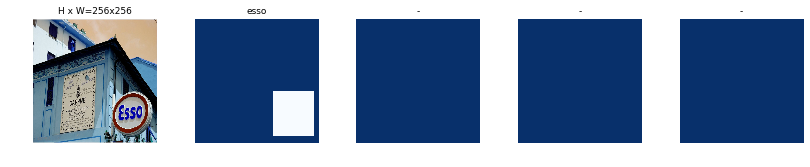

[23]


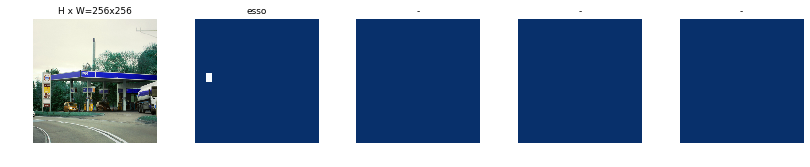

[23]


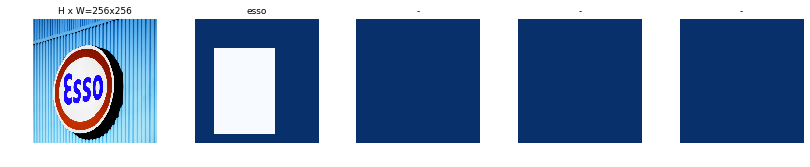

[23 23]


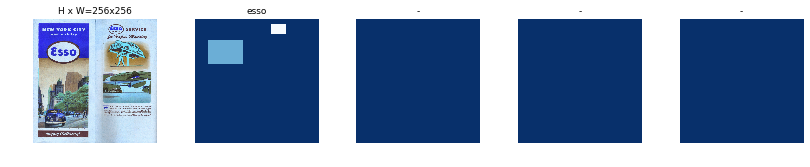

[23 23]


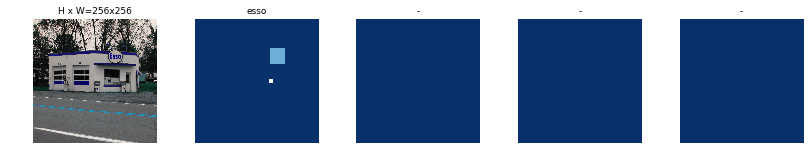

[23]


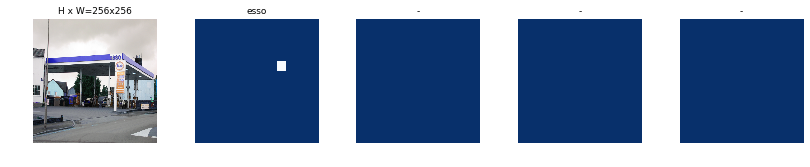

[23]


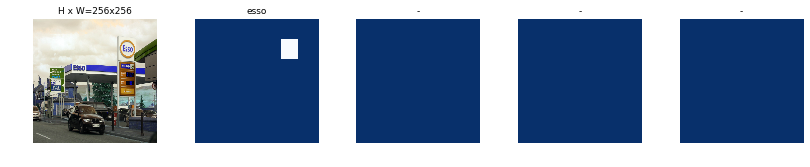

[23]


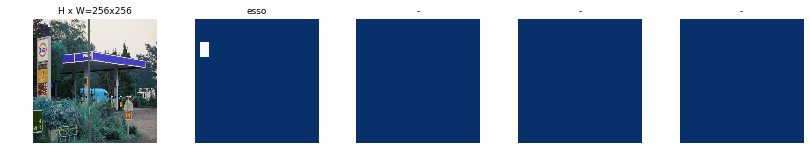

[23]


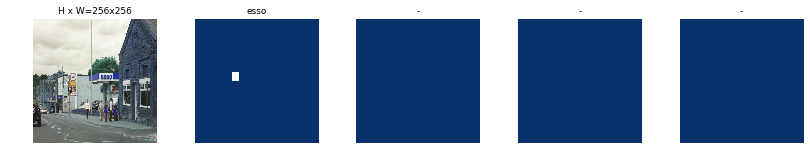

[23]


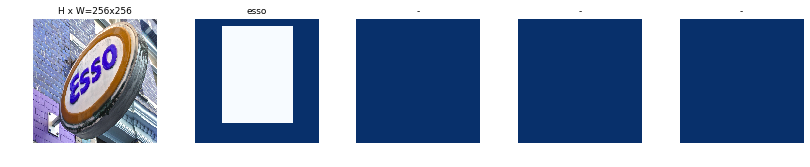

[24]


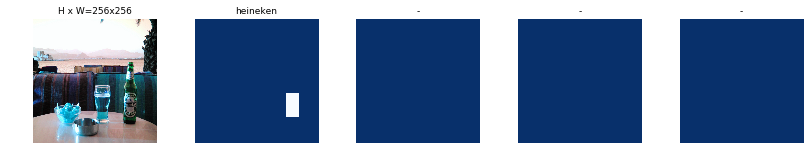

[24]


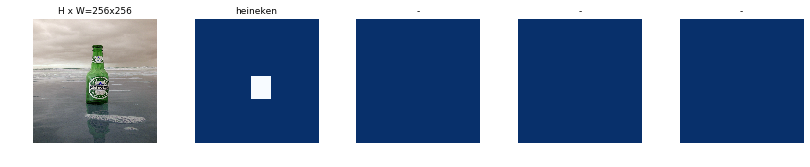

[24]


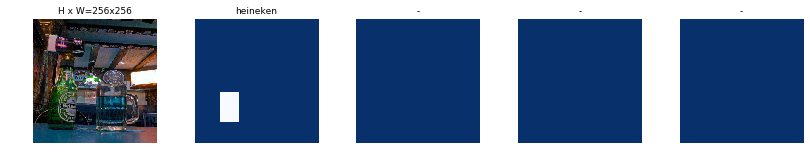

[24]


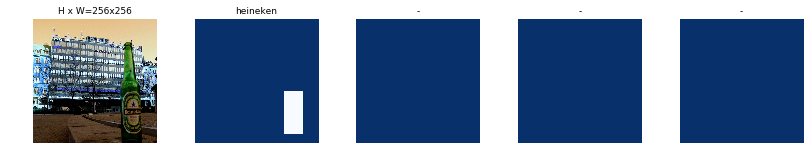

[24]


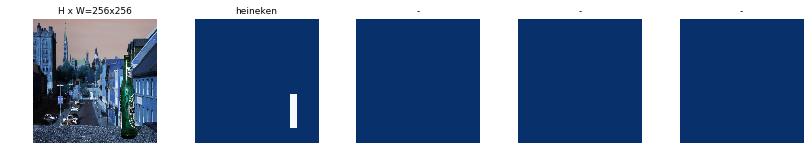

[24]


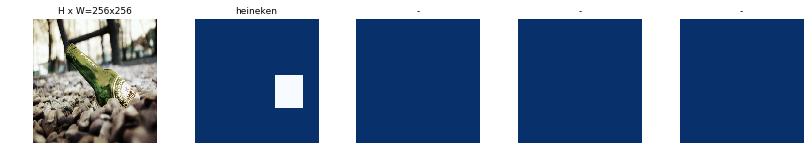

[24]


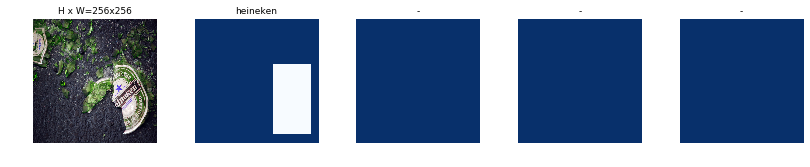

[24]


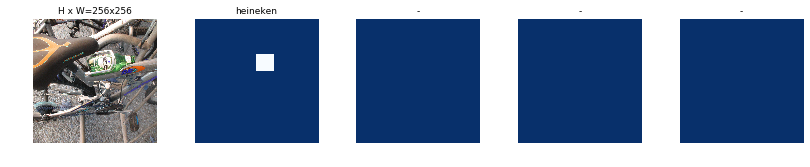

[24]


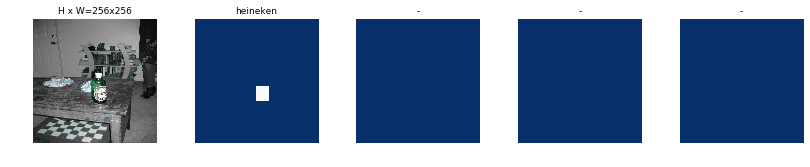

[24]


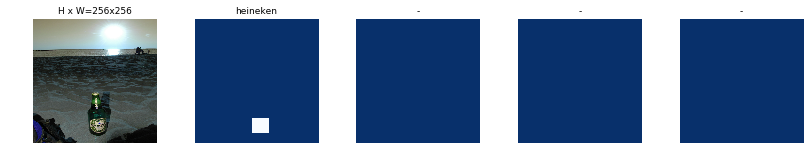

[24]


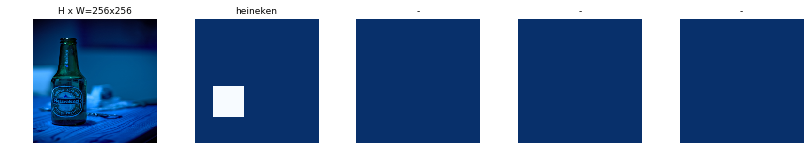

[24 24]


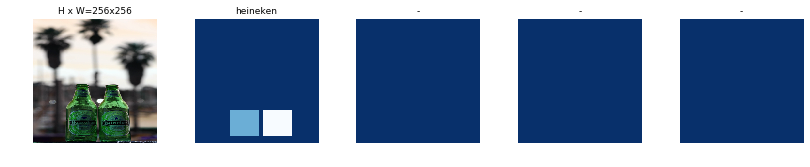

[24]


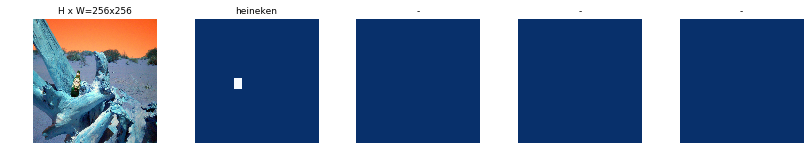

[24]


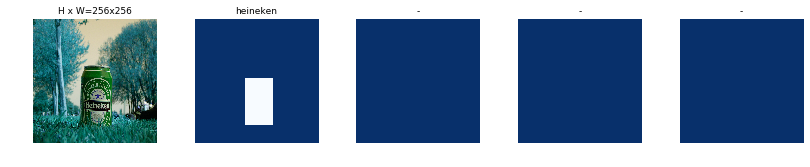

[24]


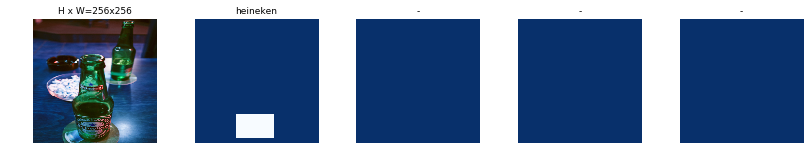

[24]


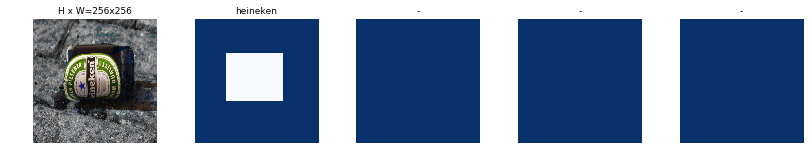

[24]


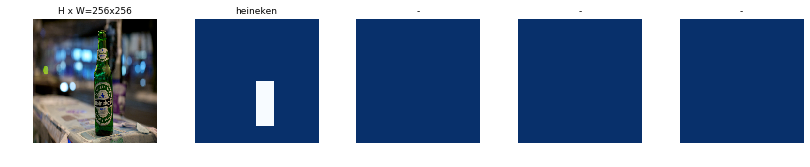

[24]


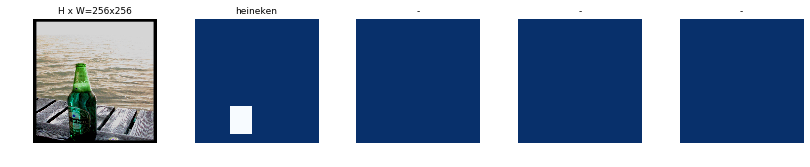

[24 24 24]


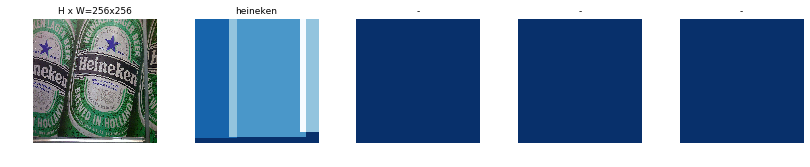

[24]


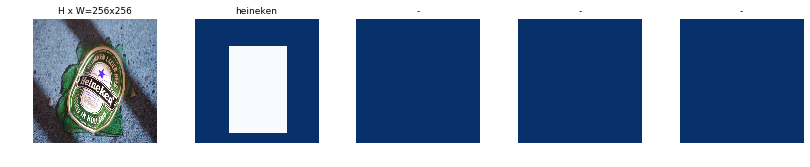

In [22]:
image_ids = df['image_id'].unique()[1000:1030]

# fig = plt.figure(figsize=(24, 64)) 
# gs = gridspec.GridSpec(10, 4 ,wspace=0.25, hspace=0.25, top=0.3, bottom=0.05, left=0.17, right=0.845) 

# for (i, img_id) in enumerate(image_ids):

#     path = BASE_DATA_DIR + 'trainval_jpg/' + img_id
#     img = cv2.imread(path)

#     img_width, img_heigth, channels = img.shape

#     image_data = df[df['image_id'] == img_id].iloc[0]
#     mask = np.zeros((img_width, img_heigth))
#     mask[image_data['y']:image_data['y'] + image_data['height'], image_data['x']:image_data['x'] + image_data['width']] = 1

#     ax1 = plt.subplot(gs[i,0])
#     ax2 = plt.subplot(gs[i,1])
#     ax1.imshow(img)
#     ax2.imshow(mask)

#     image = train_bds.load_image(i)
#     masks, brand_ids = train_bds.load_mask(i)
#     mask = masks[:, :, 0]

#     ax3 = plt.subplot(gs[i,2])
#     ax4 = plt.subplot(gs[i,3])
#     ax3.imshow(image)
#     ax4.imshow(mask)

for i in range(1000, 1030):
    image = train_bds.load_image(i)
    mask, class_ids = train_bds.load_mask(i)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, train_bds.class_names)

plt.pause(.01)

In [23]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "brands"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    # Number of classes (including background)
    NUM_CLASSES = 1 + 32  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                45
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [25]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [26]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

94658560/94653016 [==============================] - 1s 0us/step


In [27]:
model.train(train_bds, val_bds, 
            learning_rate=config.LEARNING_RATE*.1,
            epochs=5, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: ./DRIVE/My Drive/colab_data/Mask_RCNN-master/logs/brands20190924T1459/mask_rcnn_brands_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker



Epoch 1/5
100/100 [==============================] - 469s 5s/step - loss: 4.8676 - rpn_class_loss: 0.4523 - rpn_bbox_loss: 1.7894 - mrcnn_class_loss: 0.5514 - mrcnn_bbox_loss: 1.3746 - mrcnn_mask_loss: 0.7000 - val_loss: 3.8090 - val_rpn_class_loss: 0.1289 - val_rpn_bbox_loss: 1.4936 - val_mrcnn_class_loss: 0.3247 - val_mrcnn_bbox_loss: 1.1011 - val_mrcnn_mask_loss: 0.7607
Epoch 2/5
100/100 [==============================] - 294s 3s/step - loss: 3.2701 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 1.1163 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.9367 - mrcnn_mask_loss: 0.7322 - val_loss: 3.1196 - val_rpn_class_loss: 0.0728 - val_rpn_bbox_loss: 1.1292 - val_mrcnn_class_loss: 0.3656 - val_mrcnn_bbox_loss: 0.8240 - val_mrcnn_mask_loss: 0.7279
Epoch 3/5
100/100 [==============================] - 295s 3s/step - loss: 2.9766 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.0154 - mrcnn_class_loss: 0.3660 - mrcnn_bbox_loss: 0.8088 - mrcnn_mask_loss: 0.7272 - val_loss: 3.0912 - val_rpn_class_lo

In [49]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./DRIVE/My Drive/colab_data/Mask_RCNN-master/logs/brands20190924T1459/mask_rcnn_brands_0005.h5
Re-starting from epoch 5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (45,)                 min:    0.00000  max:  677.00000  int64
gt_class_id              shape: (11,)                 min:   12.00000  max:   12.00000  uint32
gt_bbox                  shape: (11, 4)               min:    0.00000  max:  255.00000  int32
gt_mask                  shape: (256, 256, 11)        min:    0.00000  max:    1.00000  bool
[12 12 12 12 12 12 12 12 12 12 12]
[[ 11  21  38  43]
 [  3 151  35 175]
 [ 22 228  56 252]
 [ 99 222 131 246]
 [ 51 186  82 209]
 [110   0 133  18]
 [103  81 134 101]
 [133  92 168 112]
 [224 179 248 202]
 [207 230 237 252]
 [237 124 255 150]]


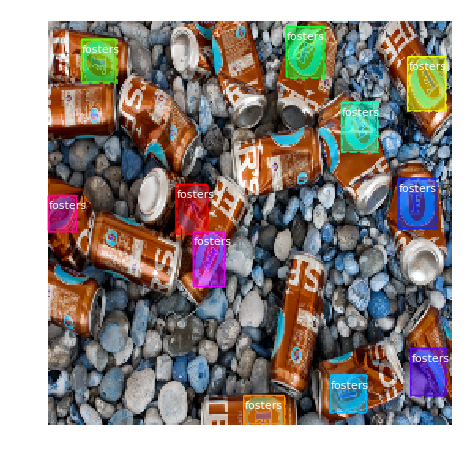

In [50]:
# Test on a random image
image_id = random.choice(val_bds.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_bds, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

print(gt_class_id)
print(gt_bbox)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_bds.class_names, figsize=(8, 8))

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 45)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(256, 256, 0), dtype=float64)}]

*** No instances to display *** 



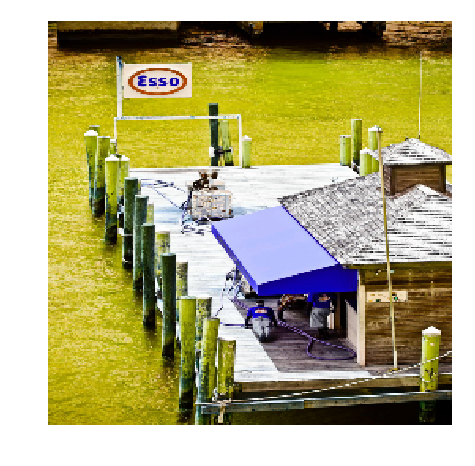

In [47]:
results = model.detect([original_image], verbose=1)
print(results)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            val_bds.class_names, r['scores'], ax=get_ax())